In [1]:
%%capture
!pip install mplhep --user

In [2]:
from ROOT import TFile
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import mplhep as hep
import ipywidgets as widget
import scipy
from scipy import stats

Welcome to JupyROOT 6.24/06


In this notebook, we evaluate how the various inputs associated with the $b$-tag analyzer vary with the $N_j$ and $N_b$ multiplicity.  These inputs are also used when deriving scale factors and viewing the input distributions can provide insight into why the scale factors derived at a certain phase space of $(N_j,N_b)$ does not extend well into other regions of the phase space.

### Define input parameters

In [3]:
filename = "Semilepton_HT500Njet9_1_mc"
#filename = "Semileptonic_1_mc"
lumitext = "Semilepton_HT500Njet9_1_mc"
rFile = TFile.Open( filename + ".root" )
rTree = rFile.Get( "btagana" ).Get( "ttree" )
savedir = "./{}".format( filename )
if not os.path.exists( savedir ):
    os.mkdir( savedir )
year = "2017"

In [4]:
wp_deepCSV = {
    "2017": {
        "LOOSE": 0.1522,
        "MEDIUM": 0.4941,
        "TIGHT": 0.8001
    }
}

## Plotting parameters
The following parameters determine how each variable is stored in histogram as well as plotted.  `BINS` is a `np.linspace()` object describing the minimum, maximum and number of bins to be plotted. `SCHEME` refers to how the variables should be accessed from the `ROOT` file because some are stored as `long` values (1), single-entry arrays (2) or arrays (3).

In [5]:
plot_params = {
    "Jet_DeepCSVb": { "BINS": np.linspace(0,1,51), "SCHEME": 3, "LATEX": "\mathrm{deepCSV}\ \mathrm{P}(b)" },
    "Jet_DeepCSVbb": { "BINS": np.linspace(0,1,51), "SCHEME": 3, "LATEX": "\mathrm{deepCSV}\ \mathrm{P}(bb)" },
    "Jet_eta": { "BINS": np.linspace(-2.8,2.8,51), "SCHEME": 3, "LATEX": "Jet\ \eta" },
    "Jet_pt": { "BINS": np.linspace(20,250,24), "SCHEME": 3, "LATEX": "Jet\ p_T" },
    "PV_x": { "BINS": np.linspace(-0.06,0.05,31), "SCHEME": 2, "LATEX": "x_{PV}" },
    "PV_y": { "BINS": np.linspace(0.02,0.12,31), "SCHEME": 2, "LATEX": "y_{PV}" },
    "PV_z": { "BINS": np.linspace(-20,20,51), "SCHEME": 2, "LATEX": "z_{PV}" },
    "PV_chi2": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "\chi^2_{SV}" },
    "SV_EnergyRatio": { "BINS": np.linspace(0,20,21), "SCHEME": 3, "LATEX": "E_{SV}\ /\ E_{Jet}" },
    "SV_chi2": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "\chi^2_{SV}" },
    "SV_flight": { "BINS": np.linspace(0,6,25), "SCHEME": 3, "LATEX": "SV\ 3D\ Flight\ Distance" },
    "SV_mass": { "BINS": np.linspace(0,7,29), "SCHEME": 3, "LATEX": "M_{SV}" },
    "SV_nTrk": { "BINS": np.linspace(0,15,16), "SCHEME": 3, "LATEX": "SV\ N_{track}" },
    "SV_vtxDistJetAxis": { "BINS": np.linspace(0,0.00015,16), "SCHEME": 3, "LATEX": "\Delta d(SV,Jet\ Axis)" },
    "SV_vtx_eta": { "BINS": np.linspace(-2.5,2.5,31), "SCHEME": 3, "LATEX": "SV\ \eta" },
    "SV_vtx_pt": { "BINS": np.linspace(0,300,31), "SCHEME": 3, "LATEX": "SV\ p_T" },
    "SV_x": { "BINS": np.linspace(0,2.5,21), "SCHEME": 3, "LATEX": "x_{SV}" },
    "SV_y": { "BINS": np.linspace(0,2.5,21), "SCHEME": 3, "LATEX": "y_{SV}" },
    "SV_z": { "BINS": np.linspace(-15,18,31), "SCHEME": 3, "LATEX": "z_{SV}" },
    "TagVarCSV_flightDistance2dSig": { "BINS": np.linspace(0,800,51), "SCHEME": 3, "LATEX": "Sig.\ \Delta d_T(PV,SV)" },
    "TagVarCSV_jetNSecondaryVertices": { "BINS": np.linspace(0,6,7), "SCHEME": 3, "LATEX": "Jet\ N_{SV}" },
    "TagVarCSV_jetNTracks": { "BINS": np.linspace(0,21,22), "SCHEME": 3, "LATEX": "Jet\ N_{tracks}" },
    "TagVarCSV_trackDecayLenVal": { "BINS": np.linspace(0,5,11), "SCHEME": 3, "LATEX": "Track\ Decay\ Length" }, # not sure about this label
    "TagVarCSV_trackDeltaR": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "\Delta r(track,jet\ axis)" }, # not sure about this label
    "TagVarCSV_trackPtRatio": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "Track\ p_T^{rel}\ / Track\ E"  }, # not sure about this label
    "TagVarCSV_trackPtRel": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "Track\ p_T^{rel}" },
    "TagVarCSV_trackSip2dSigAboveCharm": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "Sig.\ Track\ 2D\ SIP(Track\ >M_c)" },
    "TagVarCSV_trackSumJetDeltaR": { "BINS": np.linspace(0,4,41), "SCHEME": 3, "LATEX": "\Delta r(\Sigma track,j)" },
    "TagVarCSV_trackSumJetEtRatio": { "BINS": np.linspace(0,4,41), "SCHEME": 3, "LATEX": "\Sigma E^{track}_T\ /\ E^{j}" },
    "TagVarCSV_vertexEnergyRatio": { "BINS": np.linspace(0,30,31), "SCHEME": 3, "LATEX": "E^{SV}\ /\ E^{j}" },
    "TagVarCSV_vertexJetDeltaR": { "BINS": np.linspace(0,0.3,31), "SCHEME": 3, "LATEX": "\Delta r(SV,j)" },
    "TagVarCSV_vertexNTracks": { "BINS": np.linspace(0,21,22), "SCHEME": 3, "LATEX": "SV\ N_{tracks}" },
    "nJet": { "BINS": np.linspace(0,15,16), "SCHEME": 1, "LATEX": "N_j" },
    "nPV": { "BINS": np.linspace(0,122,62), "SCHEME": 1, "LATEX": "N_{PV}" },
    "nSV": { "BINS": np.linspace(0,11,12), "SCHEME": 1, "LATEX": "N_{SV}" },
    "nTrkTagVarCSV": { "BINS": np.linspace(0,84,43), "SCHEME": 1, "LATEX": "SV\ N_{track}" }
}

### 2D Histogram Plot Format Parameters
Plotting parameters for scaling the plot figure and labels based on the sample dimensions being plotted. The parameters are as follows:  
* `fig`: multiplicative scaling for the figure size based on the size of the histogram dimensions
* `textsize`: textsize for the title, x-axis and y-axis labels
* `table`: the x- and y-table scaling size to fit the figure dimensions
* `cbar`: the 2D histogram colorbar shrink size
* `shift`: the x-ticks and y-ticks coordinate shift to accomodate tables

In [116]:
plot_yscale = {
    4:  { "fig": 2 ,"textsize": 14, "table": [(1,1.6),(0.06,7.45)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    5:  { "fig": 2 ,"textsize": 14, "table": [(1,1.6),(0.06,7.45)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    6:  { "fig": 10/6 ,"textsize": 14, "table": [(1,1.6),(0.06,6.15)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    7:  { "fig": 10/7 ,"textsize": 14, "table": [(1,1.6),(0.05,5.30)], "cbar": 0.8 , "shift": [-0.07,-0.07] },
    8:  { "fig": 10/8 ,"textsize": 16, "table": [(1,1.6),(0.06,4.65)], "cbar": 0.8 , "shift": [-0.07,-0.05] },
    9:  { "fig": 12/9 ,"textsize": 16, "table": [(1,1.6),(0.04,4.40)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    10: { "fig": 12/10 ,"textsize": 20, "table": [(1,1.6),(0.04,4.45)], "cbar": 0.85 , "shift": [-0.06,-0.05] },
    11: { "fig": 14/11 ,"textsize": 20, "table": [(1,1.6),(0.04,4.75)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    12: { "fig": 14/12 ,"textsize": 20, "table": [(1,1.6),(0.04,4.35)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    13: { "fig": 14/13 ,"textsize": 22, "table": [(1,1.6),(0.04,4.00)], "cbar": 0.85 , "shift": [-0.07,-0.05] },
    14: { "fig": 15/14 ,"textsize": 22, "table": [(1,1.6),(0.03,3.98)], "cbar": 0.85 , "shift": [-0.05,-0.05] },
    15: { "fig": 16/15 ,"textsize": 22, "table": [(1,1.6),(0.03,3.98)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    16: { "fig": 17/16 ,"textsize": 22, "table": [(1,1.6),(0.03,3.95)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    17: { "fig": 1 ,"textsize": 22, "table": [(1,1.6),(0.03,3.72)], "cbar": 0.80 , "shift": [-0.04,-0.04] },
    18: { "fig": 20/18 ,"textsize": 24, "table": [(1,1.6),(0.03,4.14)], "cbar": 0.80 , "shift": [-0.04,-0.04] }
}

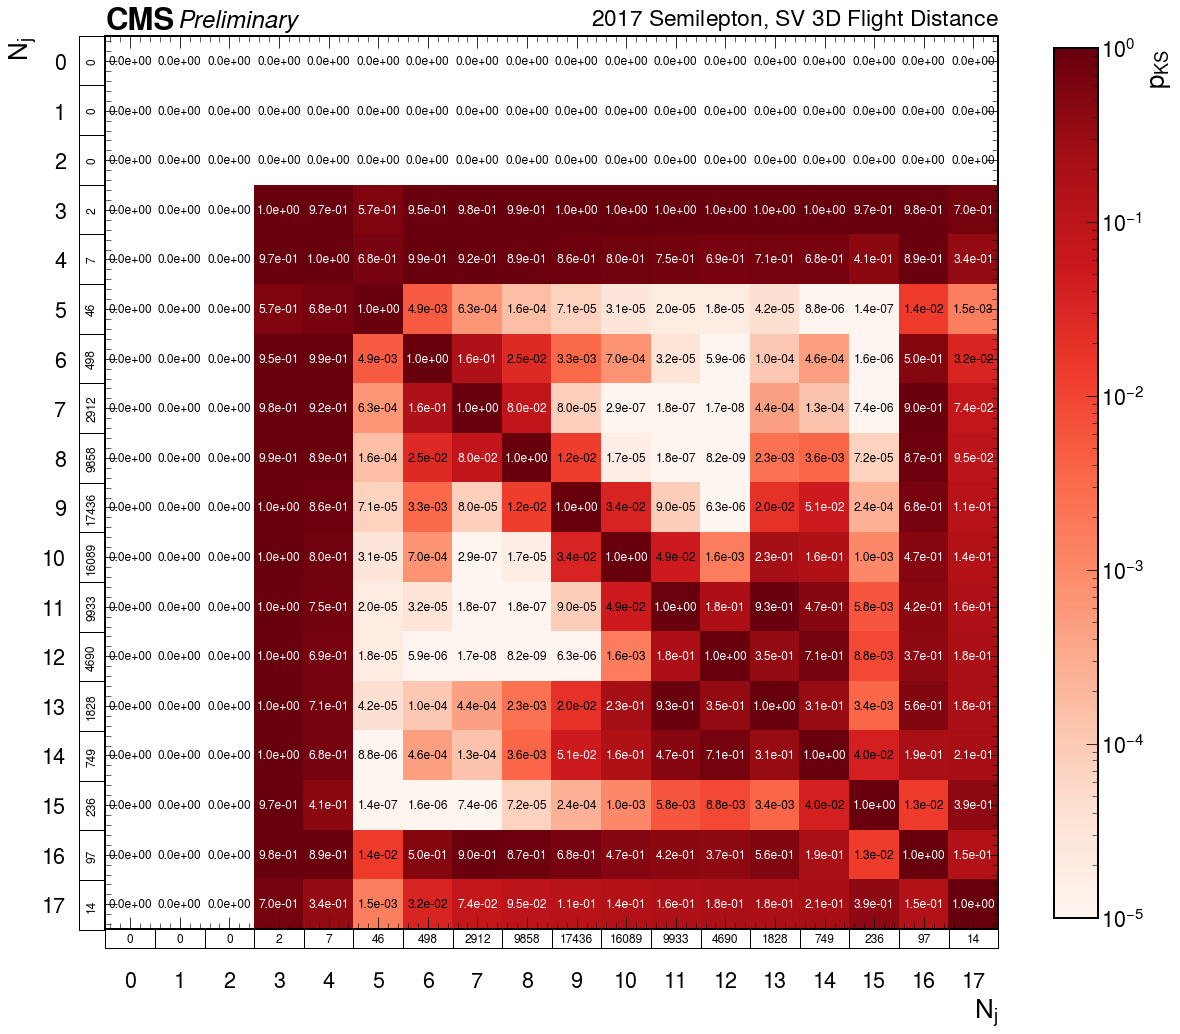

In [41]:
ys = np.shape( p_ks[ "NJET" ] )[1]
xs = np.shape( p_ks[ "NJET" ] )[0]
plot_ys = plot_yscale[ ys ]
plt.figure( figsize = ( ys*plot_ys[ "fig" ], xs*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["NJET"], cmap="Reds", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for x in range( ys ):
    for y in range( xs ):
        color = "white" if p_ks[ "NJET" ][ x ][ y ] > alpha else "black"
        plt.text( 
            x, y, "{:.1e}".format( p_ks[ "NJET" ][ x ][ y ] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ] )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ] )
plt.xlabel( "$N_j$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) for i in list( hist_nJ.keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize( 12 )
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_j$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) ] for i in list( hist_nJ.keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize( 12 )
ytable.scale( plot_ys[ "table" ][1][0], plot_ys[ "table" ][1][1] )

for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.show()
plt.close()

### Determine the jet multiplicities for each event

In [6]:
branches = [ branch.GetName() for branch in rTree.GetListOfBranches() ]
branches += [ "nbJet_l", "nbJet_m", "nbJet_t" ]

jet_per_event = {
    i: {
        "nJet": 0,
        "nbJet_l": { "ID": [], "COUNT": 0 },
        "nbJet_m": { "ID": [], "COUNT": 0 },
        "nbJet_t": { "ID": [], "COUNT": 0 }
    } for i in range( rTree.GetEntries() )
}

data = {
    i: {
        branch: [] for branch in branches
    } for i in range( rTree.GetEntries() )
}

max_jets = {
    "nJet": 0,
    "nbJet_l": 0,
    "nbJet_m": 0,
    "nbJet_t": 0
}

min_jets = {
    "nJet": 100,
    "nbJet_l": 100,
    "nbJet_m": 100,
    "nbJet_t": 100
}

for i in range( 0, rTree.GetEntries() ):
    rTree.GetEntry(i)
    nJet = getattr( rTree, "nJet" )
    jet_per_event[i][ "nJet" ] = nJet
    nB_l, nB_m, nB_t = 0, 0, 0
    
    for j in range( nJet ):
        disc_b = getattr( rTree, "Jet_DeepCSVb" )[j] + getattr( rTree, "Jet_DeepCSVbb" )[j]
        if disc_b > wp_deepCSV[ year ][ "LOOSE" ]: 
            jet_per_event[i][ "nbJet_l" ][ "ID" ].append( j )
            nB_l += 1
        if disc_b > wp_deepCSV[ year ][ "MEDIUM" ]:
            jet_per_event[i][ "nbJet_m" ][ "ID" ].append( j )
            nB_m += 1
        if disc_b > wp_deepCSV[ year ][ "TIGHT" ]: 
            jet_per_event[i][ "nbJet_t" ][ "ID" ].append( j )
            nB_t += 1
    jet_per_event[i][ "nbJet_l" ][ "COUNT" ] = nB_l
    jet_per_event[i][ "nbJet_m" ][ "COUNT" ] = nB_m
    jet_per_event[i][ "nbJet_t" ][ "COUNT" ] = nB_t
    
    if nJet > max_jets[ "nJet" ]: max_jets[ "nJet" ] = nJet
    if nB_l > max_jets[ "nbJet_l" ]: max_jets[ "nbJet_l" ] = nB_l
    if nB_m > max_jets[ "nbJet_m" ]: max_jets[ "nbJet_m" ] = nB_m
    if nB_t > max_jets[ "nbJet_t" ]: max_jets[ "nbJet_t" ] = nB_t
        
    if nJet < min_jets[ "nJet" ]: min_jets[ "nJet" ] = nJet
    if nB_l < min_jets[ "nbJet_l" ]: min_jets[ "nbJet_l" ] = nB_l
    if nB_m < min_jets[ "nbJet_m" ]: min_jets[ "nbJet_m" ] = nB_m
    if nB_t < min_jets[ "nbJet_t" ]: min_jets[ "nbJet_t" ] = nB_t

In [7]:
variable = widget.Dropdown( options = sorted( [ branch for branch in branches ] ) )
variable

Dropdown(options=('GenPVz', 'Jet_DeepCSVb', 'Jet_DeepCSVbb', 'Jet_eta', 'Jet_pt', 'PV_chi2', 'PV_x', 'PV_y', '…

### Populate the selected variable histogram

In [9]:
hist_nJ = {
    num: [] for num in range( max_jets[ "nJet"] + 1 )
}
hist_nB = {
    "LOOSE": { num: [] for num in range( max_jets[ "nbJet_l" ] + 1 ) },
    "MEDIUM": { num: [] for num in range( max_jets[ "nbJet_m" ] + 1 ) },
    "TIGHT": { num: [] for num in range( max_jets[ "nbJet_t" ] + 1 ) }
}

max_val = 0

for i in range( 0, rTree.GetEntries() ):
    rTree.GetEntry(i)
    nJ = jet_per_event[i][ "nJet" ]
    nB_l = jet_per_event[i][ "nbJet_l" ][ "COUNT" ]
    nB_m = jet_per_event[i][ "nbJet_m" ][ "COUNT" ]
    nB_t = jet_per_event[i][ "nbJet_t" ][ "COUNT" ]
    attribute = getattr( rTree, variable.value )
    
    if plot_params[ variable.value ][ "SCHEME" ] == 1:
        hist_nJ[ nJ ].append( attribute )
        hist_nB[ "LOOSE" ][ nB_l ].append( attribute )
        hist_nB[ "MEDIUM" ][ nB_m ].append( attribute )
        hist_nB[ "TIGHT" ][ nB_t ].append( attribute )
        if attribute > max_val: max_val = attribute
            
    elif plot_params[ variable.value ][ "SCHEME" ] == 2:
        hist_nJ[ nJ ].append( attribute[0] )
        hist_nB[ "LOOSE" ][ nB_l ].append( attribute[0] )
        hist_nB[ "MEDIUM" ][ nB_m ].append( attribute[0] )
        hist_nB[ "TIGHT" ][ nB_t ].append( attribute[0] )
        if attribute[0] > max_val: max_val = attribute[0]
        
    elif plot_params[ variable.value ][ "SCHEME" ] == 3:
        for j, value in enumerate( attribute ):
            hist_nJ[ nJ ].append( value )
            if j in jet_per_event[i][ "nbJet_l" ]: hist_nB[ "LOOSE" ][ nB_l ].append( value )
            if j in jet_per_event[i][ "nbJet_m" ]: hist_nB[ "MEDIUM" ][ nB_m ].append( value )
            if j in jet_per_event[i][ "nbJet_t" ]: hist_nB[ "TIGHT" ][ nB_t ].append( value )
            if value > max_val: max_val = value
        hist_nB[ "LOOSE" ][ nB_l ].append( value )
        hist_nB[ "MEDIUM" ][ nB_m ].append( value )
        hist_nB[ "TIGHT" ][ nB_t ].append( value )

### Plot the $N_j$ Histograms

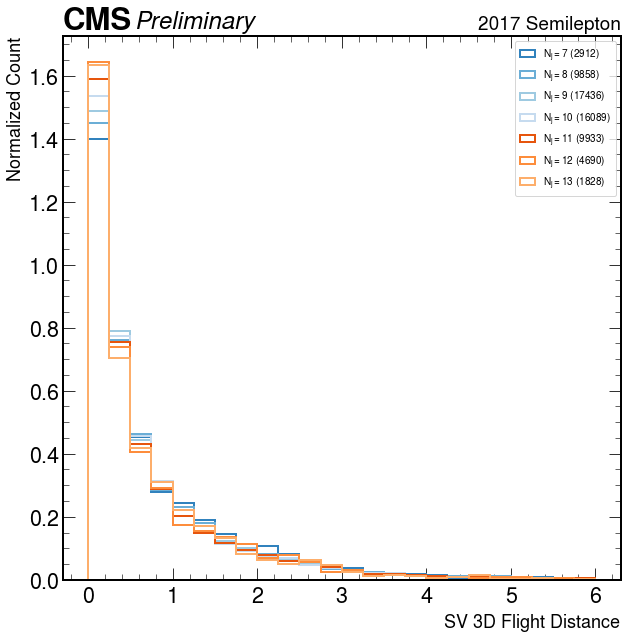

In [10]:
display = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18 ]
plt.style.use( hep.style.CMS )
plt.figure( figsize = (10,10) )
i = 0
for nJ in hist_nJ:
    if nJ not in display: continue
    if len( hist_nJ[ nJ ] ) < 1000: continue
    plt.hist(
        hist_nJ[ nJ ], bins = plot_params[ variable.value ][ "BINS" ], label = "$N_j={}$ ({})".format( nJ, len( hist_nJ[ nJ ] ) ),
        density = True, alpha = 1.0, histtype = "step", linewidth = 2, color = cm.tab20c.colors[ i ]
    )
    i += 1
hep.cms.text( "Preliminary", fontsize = 24 )
hep.cms.lumitext( "{} {}".format( year, lumitext ), fontsize = 20 )
plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
plt.xlabel( "${}$".format( plot_params[ variable.value ][ "LATEX" ] ), x = 1.0, ha = "right", fontsize = 18 )
plt.legend( loc = "best", fontsize = 10, frameon = True, framealpha = 0.8, borderpad = 0.5 )
plt.savefig( "{}/{}".format( savedir, "{}_nJ_HIST_{}.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

### Plot the $N_b$ Histograms

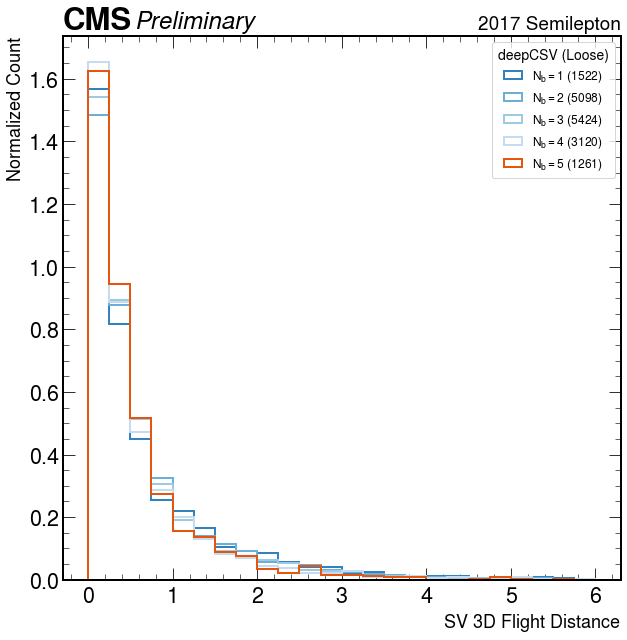

In [11]:
display = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ]
plt.figure( figsize = (10,10) )
i = 0
for nB in hist_nB[ "LOOSE" ]:
    if nB not in display: continue
    if len( hist_nB[ "LOOSE" ][ nB ] ) < 1000: continue
    plt.hist(
        hist_nB[ "LOOSE" ][ nB ], bins = plot_params[ variable.value ][ "BINS" ], 
        label = "$N_b={}$ ({})".format( nB, len( hist_nB[ "LOOSE" ][ nB ] ) ),
        density = True, alpha = 1.0, histtype = "step", linewidth = 2, color = cm.tab20c.colors[ i ]
    )
    i += 1
hep.cms.text( "Preliminary", fontsize = 24 )
hep.cms.lumitext( "{} {}".format( year, lumitext ), fontsize = 20 )
plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
plt.xlabel( "${}$".format( plot_params[ variable.value ][ "LATEX" ] ), x = 1.0, ha = "right", fontsize = 18 )
plt.legend( title = "deepCSV (Loose)", loc = "best", fontsize = 12, title_fontsize = 14, borderpad = 0.5, frameon =  True, framealpha = 0.8 )
plt.savefig( "{}/{}".format( savedir, "{}_nbL_Hist_{}.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

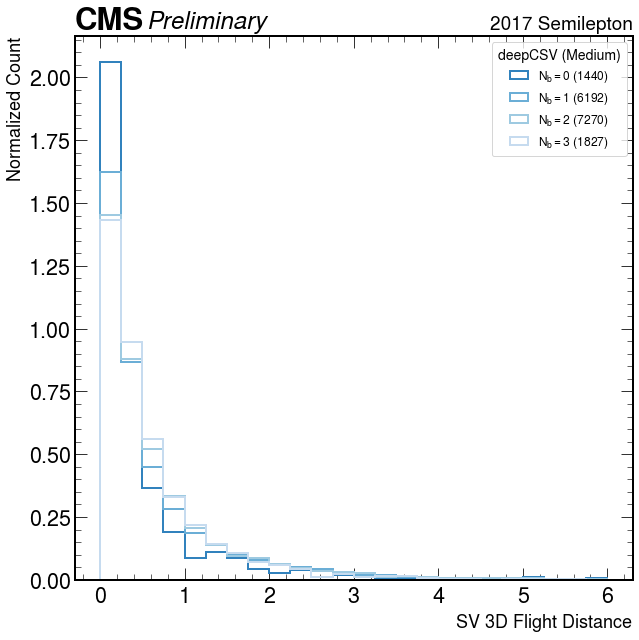

In [12]:
display = [ 0, 1, 2, 3, 4, 5, 6, 7 ]
plt.figure( figsize = (10,10) )
i = 0
for nB in hist_nB[ "MEDIUM" ]:
    if nB not in display: continue
    if len( hist_nB[ "MEDIUM" ][ nB ] ) < 1000: continue
    plt.hist(
        hist_nB[ "MEDIUM" ][ nB ], bins = plot_params[ variable.value ][ "BINS" ], 
        label = "$N_b={}$ ({})".format( nB, len( hist_nB[ "MEDIUM" ][ nB ] ) ),
        density = True, alpha = 1.0, histtype = "step", linewidth = 2, color = cm.tab20c.colors[ i ]
    )
    i += 1
hep.cms.text( "Preliminary", fontsize = 24 )
hep.cms.lumitext( "{} {}".format( year, lumitext ), fontsize = 20 )
plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
plt.xlabel( "${}$".format( plot_params[ variable.value ][ "LATEX" ] ), x = 1.0, ha = "right", fontsize = 18 )
plt.legend( title = "deepCSV (Medium)", loc = "best", fontsize = 12, title_fontsize = 14, frameon = True, framealpha = 0.8 )
plt.savefig( "{}/{}".format( savedir, "{}_nbM_Hist_{}.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

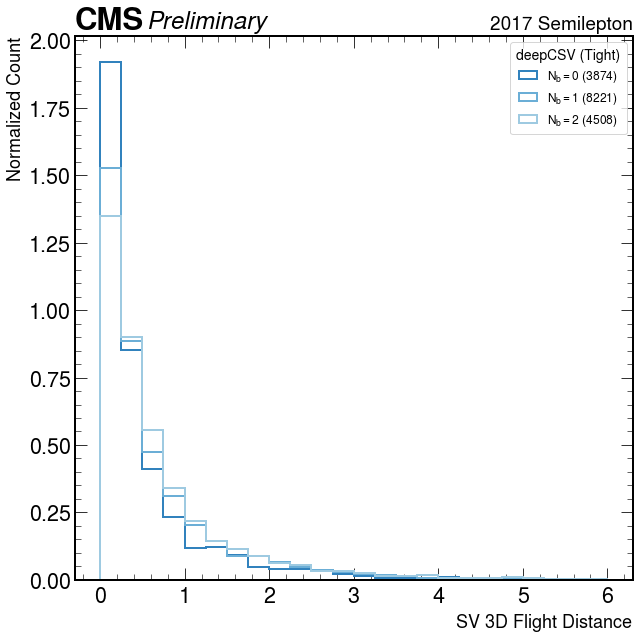

In [13]:
display = [ 0, 1, 2, 3, 4, 5 ]
plt.figure( figsize = (10,10) )
i = 0
for nB in hist_nB[ "TIGHT" ]:
    if nB not in display: continue
    if len( hist_nB[ "TIGHT" ][ nB ] ) < 1000: continue
    plt.hist(
        hist_nB[ "TIGHT" ][ nB ], bins = plot_params[ variable.value ][ "BINS" ],
        label = "$N_b={}$ ({})".format( nB, len( hist_nB[ "TIGHT" ][ nB ] ) ),
        density = True, alpha = 1.0, histtype = "step", linewidth = 2, color = cm.tab20c.colors[ i ]
    )
    i += 1
hep.cms.text( "Preliminary", fontsize = 24 )
hep.cms.lumitext( "{} {}".format( year, lumitext ), fontsize = 20 )
plt.ylabel( "Normalized Count", y = 1.0, ha = "right", fontsize = 18 )
plt.xlabel( "${}$".format( plot_params[ variable.value ][ "LATEX" ] ), x = 1.0, ha = "right", fontsize = 18 )
plt.legend( title = "deepCSV (Tight)", loc = "best", fontsize = 12, title_fontsize = 14, frameon = True, framealpha = 0.8 )
plt.savefig( "{}/{}".format( savedir, "{}_nbT_Hist_{}.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

### Calculate Kolmogorov-Smirnov Statistic for $N_j$ vs $N_j$ Histograms

In [45]:
p_ks = {
    "NJET": np.zeros( ( max_jets[ "nJet" ] + 1, max_jets[ "nJet" ] + 1 ) )
}

alpha = 0.05

for x in range( 0, max_jets[ "nJet" ] + 1 ):
    for y in range( 0, max_jets[ "nJet" ] + 1 ):
        if hist_nJ[ x ] == [] or hist_nJ[ y ] == []: continue
        else: _, p_ks[ "NJET" ][x][y] = scipy.stats.ks_2samp( hist_nJ[ x ], hist_nJ[ y ] )

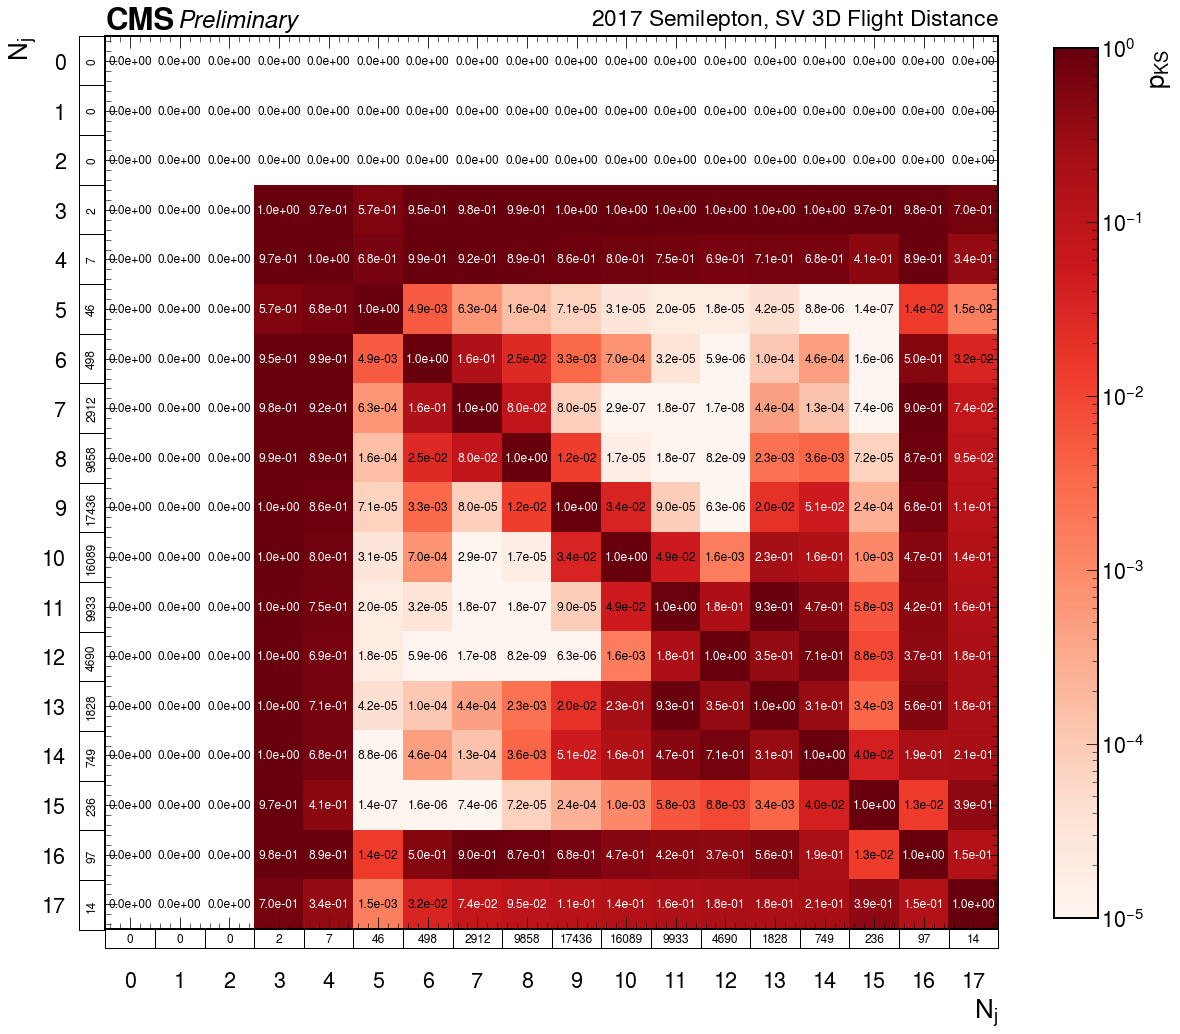

In [46]:
ys = np.shape( p_ks[ "NJET" ] )[1]
xs = np.shape( p_ks[ "NJET" ] )[0]
plot_ys = plot_yscale[ ys ]
plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["NJET"], cmap="Reds", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for x in range( ys ):
    for y in range( xs ):
        color = "white" if p_ks[ "NJET" ][ x ][ y ] > alpha else "black"
        plt.text( 
            x, y, "{:.1e}".format( p_ks[ "NJET" ][ x ][ y ] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ] )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ] )
plt.xlabel( "$N_j$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) for i in list( hist_nJ.keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize( 12 )
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_j$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) ] for i in list( hist_nJ.keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize( 12 )
ytable.scale( plot_ys[ "table" ][1][0], plot_ys[ "table" ][1][1] )

for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nJnJ_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

### Calculate Kolmogorov-Smirnov Statistic for $N_b$ vs $N_b$ Histograms

In [81]:
p_ks = {
    "LOOSE": np.zeros( ( max_jets[ "nbJet_l" ] + 1, max_jets[ "nbJet_l" ] + 1 ) ),
    "MEDIUM": np.zeros( ( max_jets[ "nbJet_m" ] + 1, max_jets[ "nbJet_m" ] + 1 ) ),
    "TIGHT": np.zeros( ( max_jets[ "nbJet_t" ] + 1, max_jets[ "nbJet_t" ] + 1 ) )
}

alpha = 0.05

for x in range( 0, max_jets[ "nbJet_l" ] + 1 ):
    for y in range( 0, max_jets[ "nbJet_l" ] + 1 ):
        if hist_nB[ "LOOSE" ][ x ] == [] or hist_nB[ "LOOSE" ][ y ] == []: continue
        else: _, p_ks[ "LOOSE" ][x][y] = scipy.stats.ks_2samp( hist_nB[ "LOOSE" ][x], hist_nB[ "LOOSE" ][y] )
for x in range( 0, max_jets[ "nbJet_m" ] + 1 ):
    for y in range( 0, max_jets[ "nbJet_m" ] + 1 ):
        if hist_nB[ "MEDIUM" ][ x ] == [] or hist_nB[ "MEDIUM" ][ y ] == []: continue
        else: _, p_ks[ "MEDIUM" ][x][y] = scipy.stats.ks_2samp( hist_nB[ "MEDIUM" ][x], hist_nB[ "MEDIUM" ][y] )
for x in range( 0, max_jets[ "nbJet_t" ] + 1 ):
    for y in range( 0, max_jets[ "nbJet_t" ] + 1 ):
        if hist_nB[ "TIGHT" ][x] == [] or hist_nB[ "TIGHT" ][y] == []: continue
        else: _, p_ks[ "TIGHT" ][x][y] = scipy.stats.ks_2samp( hist_nB[ "TIGHT" ][x], hist_nB[ "TIGHT" ][y] )

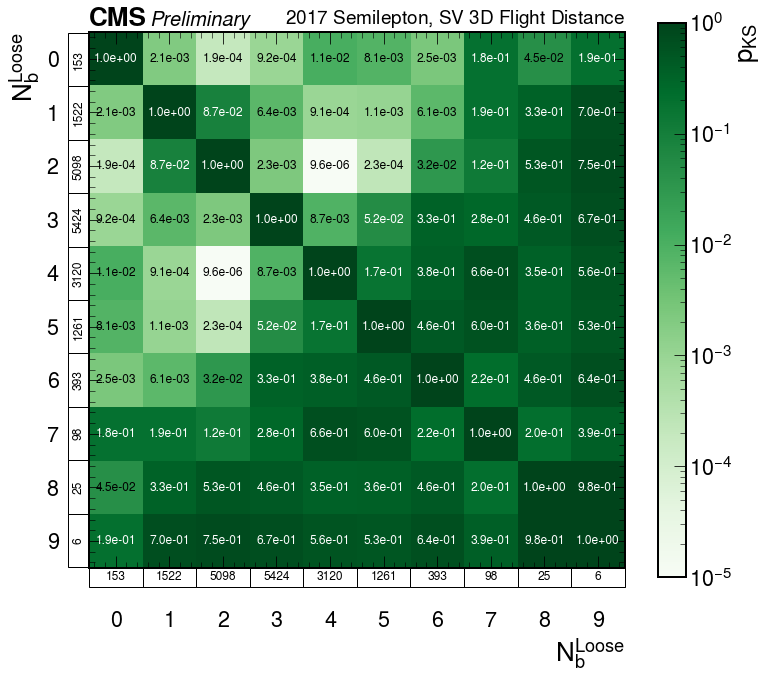

In [86]:
xs = np.shape( p_ks[ "LOOSE" ] )[0]
ys = np.shape( p_ks[ "LOOSE" ] )[1]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["LOOSE"], cmap="Greens", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for x in range( xs ):
    for y in range( ys ):
        color = "white" if p_ks[ "LOOSE" ][x][y] > alpha else "black"
        plt.text( 
            x, y, "{:.1e}".format( p_ks[ "LOOSE" ][x][y] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ] )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ] )
plt.xlabel( "$N_b^{Loose}$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nB[ "LOOSE" ][i] ) ) for i in list( hist_nB[ "LOOSE" ].keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Loose}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "LOOSE" ][i] ) ) ] for i in list( hist_nB[ "LOOSE" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0], plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )

plt.savefig( "{}/{}".format( savedir, "{}_{}_nBnB_l_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

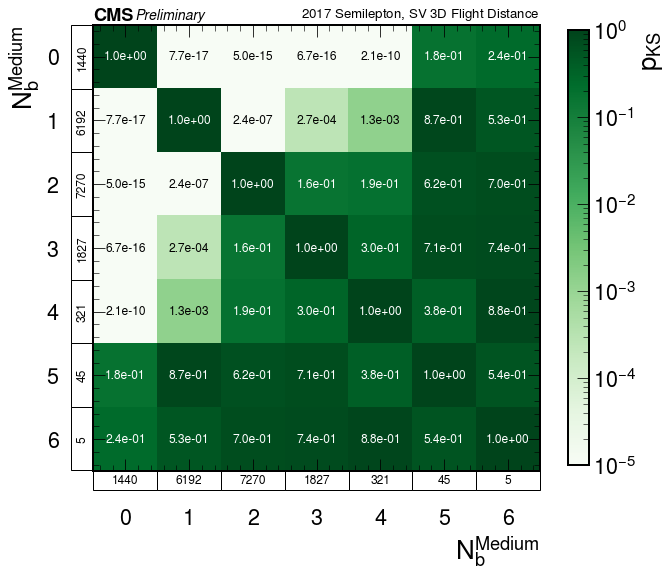

In [70]:
xs = np.shape( p_ks[ "MEDIUM" ] )[0]
ys = np.shape( p_ks[ "MEDIUM" ] )[1]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["MEDIUM"], cmap="Greens", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for x in range( xs ):
    for y in range( ys ):
        color = "white" if p_ks[ "MEDIUM" ][x][y] > alpha else "black"
        plt.text( 
            x, y, "{:.1e}".format( p_ks[ "MEDIUM" ][x][y] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ] )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ] )
plt.xlabel( "$N_b^{Medium}$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nB[ "MEDIUM" ][i] ) ) for i in list( hist_nB[ "MEDIUM" ].keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Medium}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "MEDIUM" ][i] ) ) ] for i in list( hist_nB[ "MEDIUM" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0], plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nBnB_m_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

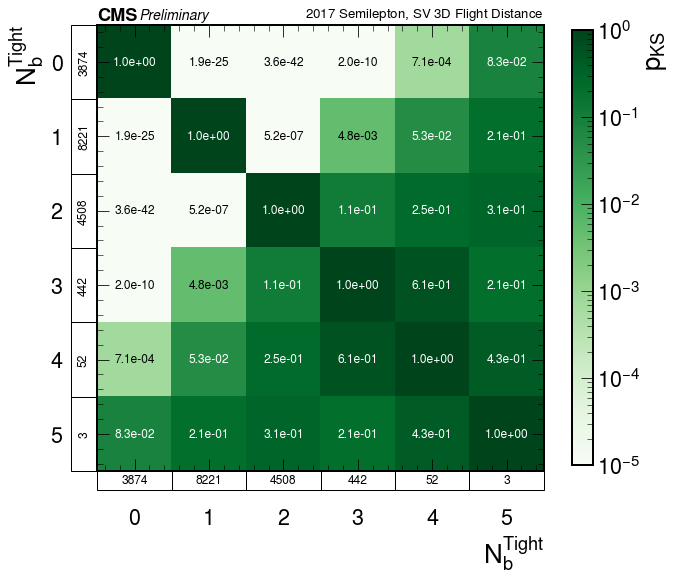

In [72]:
xs = np.shape( p_ks[ "TIGHT" ] )[0]
ys = np.shape( p_ks[ "TIGHT" ] )[1]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["TIGHT"], cmap="Greens", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for x in range( xs ):
    for y in range( ys ):
        color = "white" if p_ks[ "TIGHT" ][x][y] > alpha else "black"
        plt.text( 
            x, y, "{:.1e}".format( p_ks[ "TIGHT" ][x][y] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ] )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ] )
plt.xlabel( "$N_b^{Tight}$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nB[ "TIGHT" ][i] ) ) for i in list( hist_nB[ "TIGHT" ].keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Tight}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "TIGHT" ][i] ) ) ] for i in list( hist_nB[ "TIGHT" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0], plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nBnB_t_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

### Calculate Kolmogorov-Smirnov Statistic for $N_j$ vs $N_b$ Histograms

In [87]:
p_ks = {
    "LOOSE": np.zeros( ( max_jets[ "nbJet_l" ] + 1, max_jets[ "nJet" ] + 1 ) ),
    "MEDIUM": np.zeros( ( max_jets[ "nbJet_m" ] + 1, max_jets[ "nJet" ] + 1 ) ),
    "TIGHT": np.zeros( ( max_jets[ "nbJet_t" ] + 1, max_jets[ "nJet" ] + 1 ) )
}

alpha = 0.05

for nJ in range( 0, max_jets[ "nJet" ] + 1 ):
    for nB in range( 0, max_jets[ "nbJet_l" ] + 1 ):
        if hist_nJ[ nJ ] == [] or hist_nB[ "LOOSE" ][ nB ] == []: continue
        else: _, p_ks[ "LOOSE" ][nB][nJ] = scipy.stats.ks_2samp( hist_nB[ "LOOSE" ][ nB ], hist_nJ[ nJ ] )
    for nB in range( min_jets[ "nbJet_m" ], max_jets[ "nbJet_m" ] ):
        if hist_nJ[ nJ ] == [] or hist_nB[ "MEDIUM" ][ nB ] == []: continue
        else: _, p_ks[ "MEDIUM" ][nB][nJ] = scipy.stats.ks_2samp( hist_nB[ "MEDIUM" ][ nB ], hist_nJ[ nJ ] )
    for nB in range( min_jets[ "nbJet_t" ], max_jets[ "nbJet_t" ] ):
        if hist_nJ[ nJ ] == [] or hist_nB[ "TIGHT" ][ nB ] == []: continue
        else: _, p_ks[ "TIGHT" ][nB][nJ] = scipy.stats.ks_2samp( hist_nB[ "TIGHT" ][ nB ], hist_nJ[ nJ ] )


Plot for `deepCSV Loose`

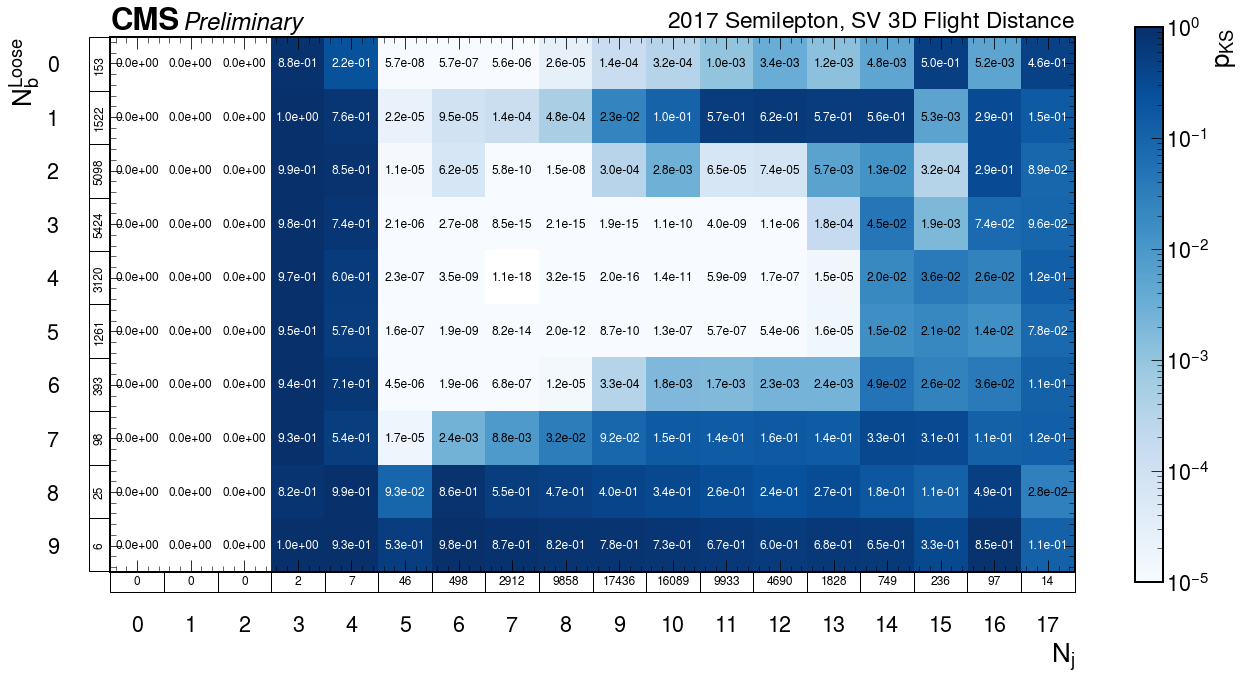

In [90]:
xs = np.shape( p_ks[ "LOOSE" ] )[1]
ys = np.shape( p_ks[ "LOOSE" ] )[0]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["LOOSE"], cmap="Blues", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for nB in range( ys ):
    for nJ in range( xs ):
        color = "white" if p_ks[ "LOOSE" ][ nB ][ nJ ] > alpha else "black"
        plt.text( 
            nJ, nB, "{:.1e}".format( p_ks[ "LOOSE" ][ nB ][ nJ ] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ]*1.2 )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ]*1.2 )
plt.xlabel( "$N_j$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) for i in list( hist_nJ.keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Loose}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1]
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "LOOSE" ][i] ) ) ] for i in list( hist_nB[ "LOOSE" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0] * ys/xs, plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nJnB_l_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

Plot for `deepCSV Medium`

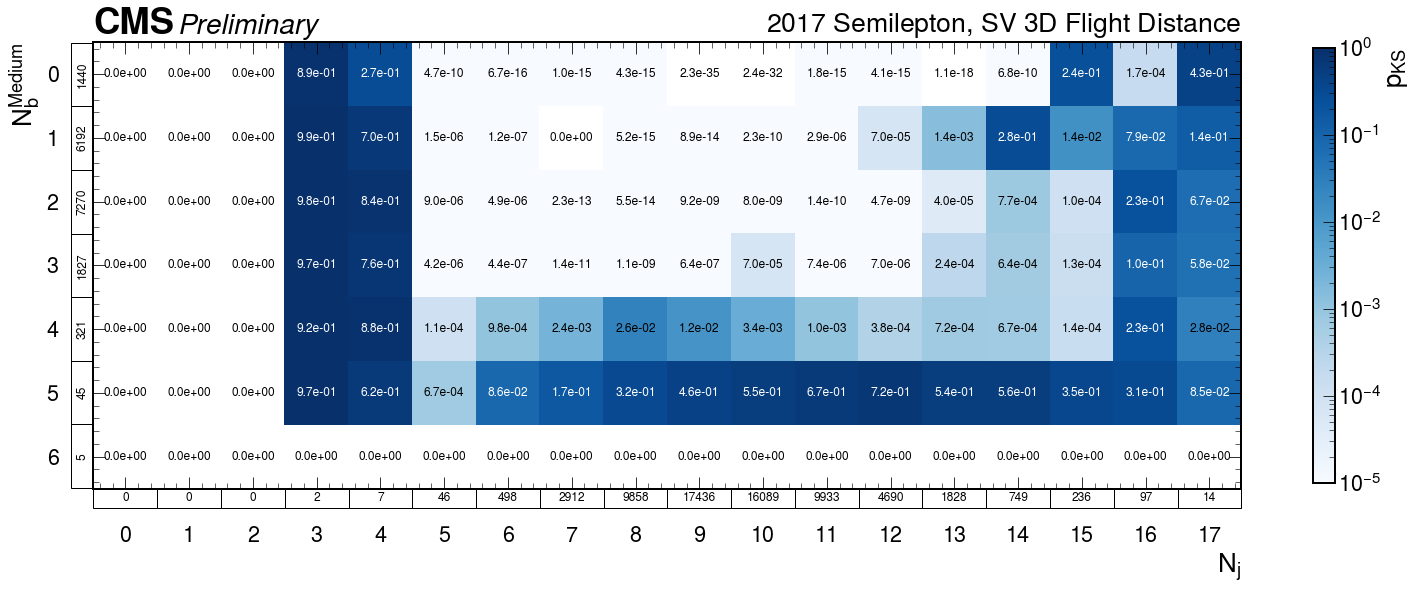

In [98]:
xs = np.shape( p_ks[ "MEDIUM" ] )[1]
ys = np.shape( p_ks[ "MEDIUM" ] )[0]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["MEDIUM"], cmap="Blues", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for nB in range( ys ):
    for nJ in range( xs ):
        color = "white" if p_ks[ "MEDIUM" ][ nB ][ nJ ] > alpha else "black"
        plt.text( 
            nJ, nB, "{:.1e}".format( p_ks[ "MEDIUM" ][ nB ][ nJ ] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ]*2 )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ]*2 )
plt.xlabel( "$N_j$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) for i in list( hist_nJ.keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Medium}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1] * ys/xs
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "MEDIUM" ][i] ) ) ] for i in list( hist_nB[ "MEDIUM" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0] * ys/xs , plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nJnB_m_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()

Plot for `deepCSV Tight`

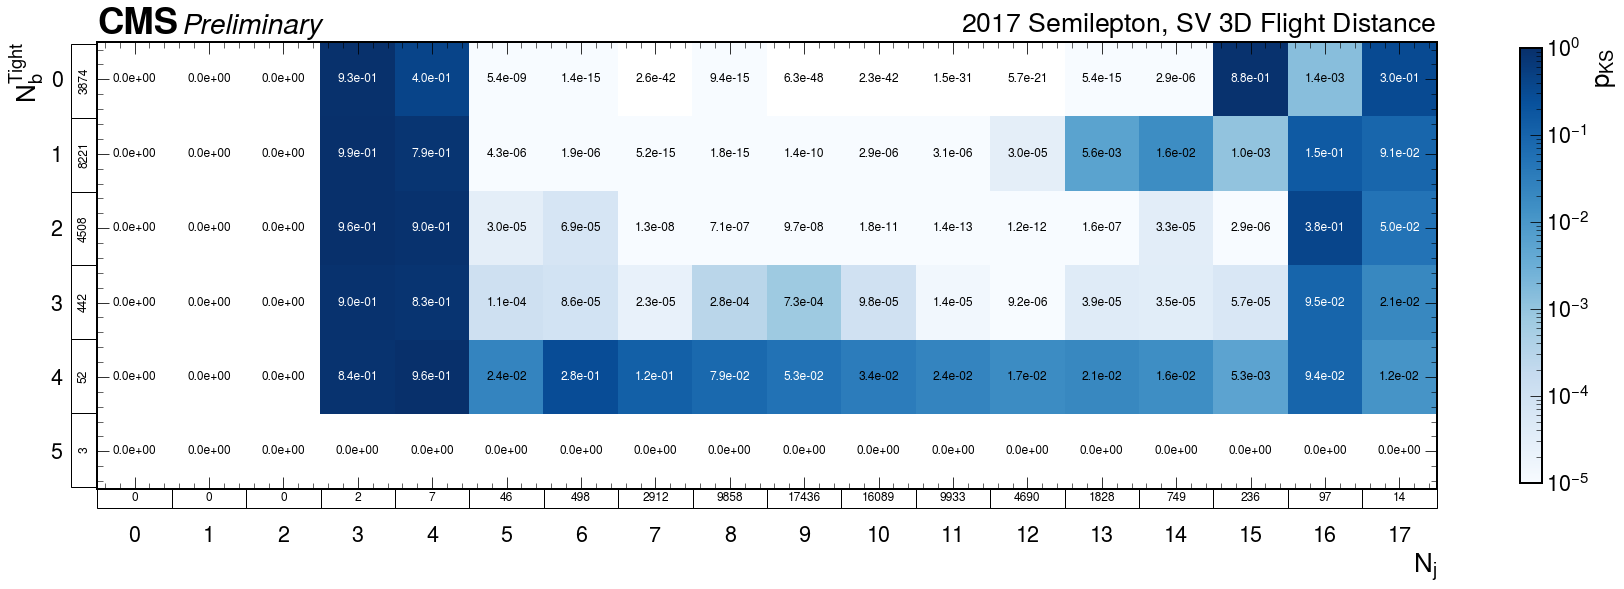

In [117]:
xs = np.shape( p_ks[ "TIGHT" ] )[1]
ys = np.shape( p_ks[ "TIGHT" ] )[0]
plot_ys = plot_yscale[ ys ]

plt.figure( figsize = ( xs*plot_ys[ "fig" ], ys*plot_ys[ "fig" ] ) )
plt.imshow( p_ks["TIGHT"], cmap="Blues", norm = colors.LogNorm( vmin = 1e-5, vmax = 1.0 ) )
plt.colorbar( label = "$p_{KS}$", shrink = plot_ys[ "cbar" ] )
for nB in range( ys ):
    for nJ in range( xs ):
        color = "white" if p_ks[ "TIGHT" ][ nB ][ nJ ] > alpha else "black"
        plt.text( 
            nJ, nB, "{:.1e}".format( p_ks[ "TIGHT" ][ nB ][ nJ ] ),
            ha = "center", va = "center", fontsize = 12, color = color
        )
hep.cms.text( "Preliminary", fontsize = plot_ys[ "textsize" ]*2 )
hep.cms.lumitext( "{} {}, ${}$".format( year, lumitext, plot_params[ variable.value ][ "LATEX" ] ), fontsize = plot_ys[ "textsize" ]*2 )
plt.xlabel( "$N_j$" )
plt.xticks( 
    ticks = list( range( xs ) ), 
    labels = list( range( xs ) ),
    y = plot_ys[ "shift" ][0]
)
xtable = plt.table(
    cellText = [ [ str( len( hist_nJ[i] ) ) for i in list( hist_nJ.keys() ) ] ],
    loc = "bottom", cellLoc = "center"
)
xtable.set_fontsize(12)
xtable.scale( plot_ys[ "table" ][0][0], plot_ys[ "table" ][0][1] )
plt.ylabel( "$N_b^{Tight}$" )
plt.yticks( 
    ticks = list( range( ys ) ), 
    labels = list( range( ys ) ),
    x = plot_ys[ "shift" ][1] * ys/xs
)
ytable = plt.table(
    cellText = [ [ str( len( hist_nB[ "TIGHT" ][i] ) ) ] for i in list( hist_nB[ "TIGHT" ].keys() ) ],
    loc = "left", cellLoc = "center"
)
ytable.set_fontsize(12)
ytable.scale( plot_ys[ "table" ][1][0] * ys/xs , plot_ys[ "table" ][1][1] )
for key in ytable._cells:
    ytable._cells[key].set_text_props( rotation = "vertical" )
    
plt.savefig( "{}/{}".format( savedir, "{}_{}_nJnB_t_pKS.png".format( filename, variable.value ) ) )
plt.show()
plt.close()